In [24]:
import pandas as pd
import glob
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt



plt.style.use('fivethirtyeight')
plt.rcParams["figure.figsize"] = (20,10)

# Preparing Kolding Data

In [25]:
# Load Data
path = r'../data/kolding/'
files = glob.glob(path + "/*.csv")

dfs = []

for file in files:
    df = pd.read_csv(file, index_col=None, header=0)
    dfs.append(df)

kld = pd.concat(dfs, axis=0, ignore_index=True)
kld.Datetime = pd.to_datetime(kld.Datetime)
kld = kld.groupby('Datetime').sum()

In [26]:
kld.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Value,19128.0,89.098807,33.113893,0.0,65.2555,81.6715,106.5105,263.164


### Handling Missing Values

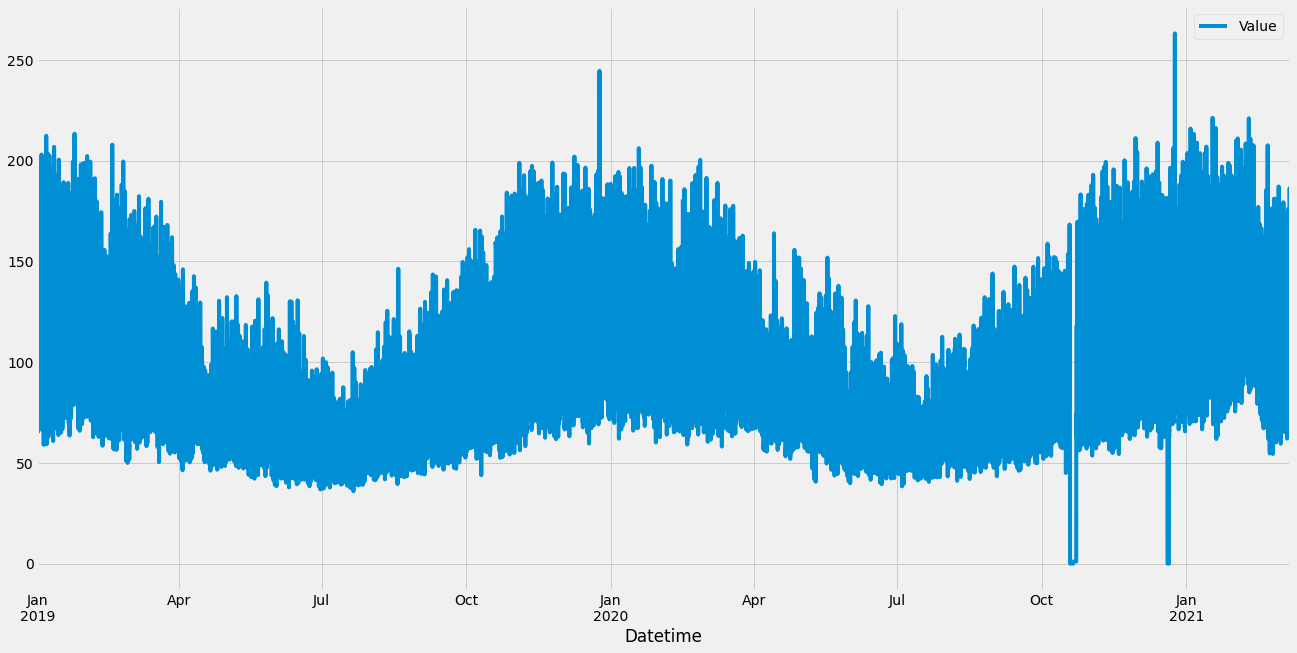

In [4]:
kld.plot()
plt.show()

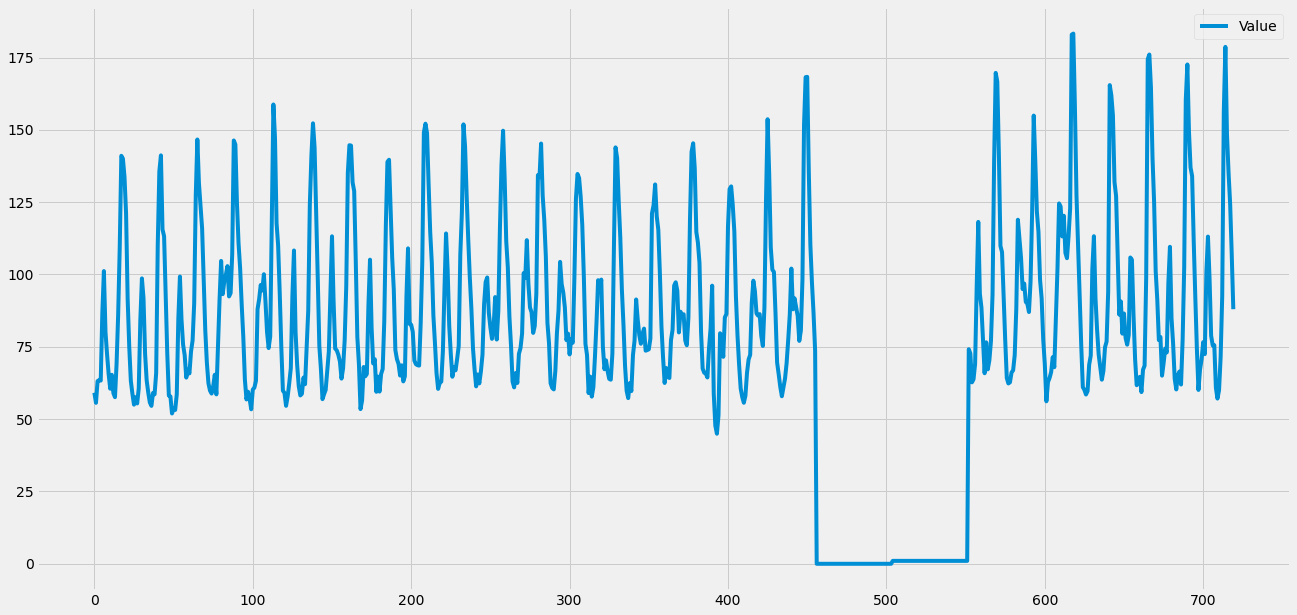

In [5]:
pd.read_csv('../data/kolding/7_kld_202010.csv', index_col=None, header=0).plot()
plt.show()

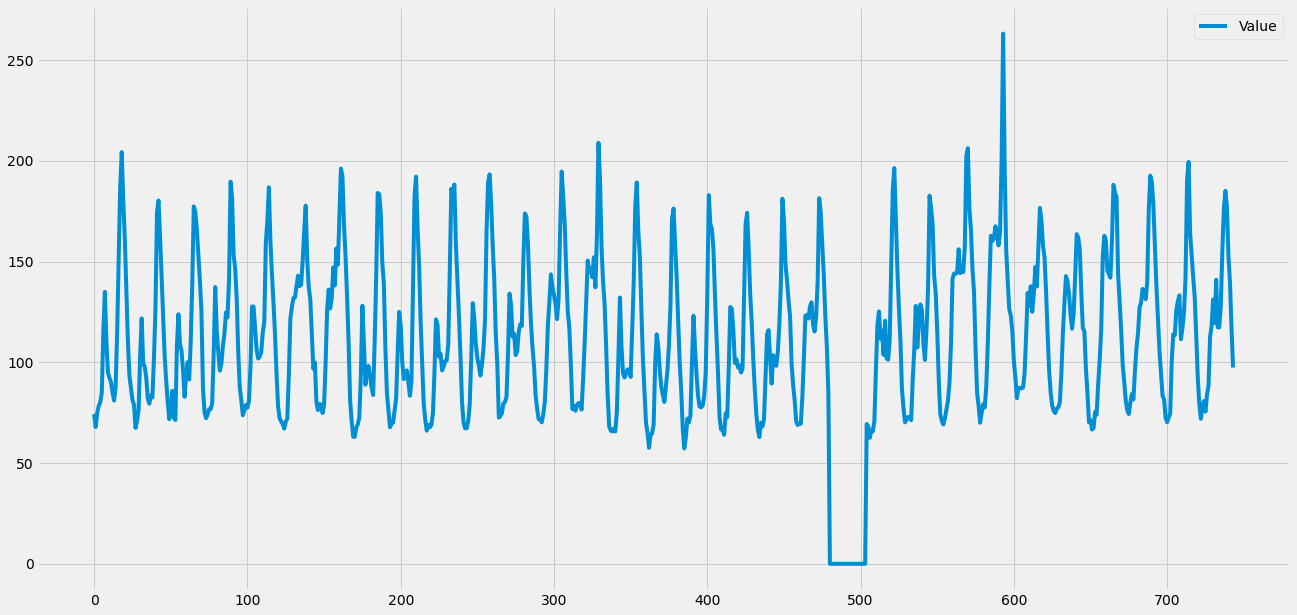

In [6]:
pd.read_csv('../data/kolding/9_kld_202012.csv', index_col=None, header=0).plot()
plt.show()

The plots show two time periods where there is missing data. In the October plot the missing data runs over a 4-day period; one day showing zeros and the next day shows a constant low value of 1.01.  
The december data shows a constant 0 aswell.

In [27]:
def replacenan(df):
    nans = df[df.Value < 10]['Value'].unique()
    for nan in nans:
        df.replace(nan, np.nan, inplace=True)

replacenan(kld)

In [28]:
np.unique(kld[kld['Value'].isna() == True].index.date)

array([datetime.date(2020, 10, 19), datetime.date(2020, 10, 20),
       datetime.date(2020, 10, 21), datetime.date(2020, 10, 22),
       datetime.date(2020, 12, 20)], dtype=object)

In [7]:
print(kld[kld.Value.isna()].index.day.unique())
print(kld[kld.Value.isna()].index.month.unique())

Int64Index([19, 20, 21, 22], dtype='int64', name='Datetime')
Int64Index([10, 12], dtype='int64', name='Datetime')


In [15]:
print(kld[kld.index == dt.datetime(2020,10,19)].index.dayofweek)
print(kld[kld.index == dt.datetime(2020,10,20)].index.dayofweek)
print(kld[kld.index == dt.datetime(2020,10,21)].index.dayofweek)
print(kld[kld.index == dt.datetime(2020,10,22)].index.dayofweek)
print(kld[kld.index == dt.datetime(2020,12,19)].index.dayofweek)
print(kld[kld.index == dt.datetime(2020,12,20)].index.dayofweek)

Int64Index([0], dtype='int64', name='Datetime')
Int64Index([1], dtype='int64', name='Datetime')
Int64Index([2], dtype='int64', name='Datetime')
Int64Index([3], dtype='int64', name='Datetime')
Int64Index([5], dtype='int64', name='Datetime')
Int64Index([6], dtype='int64', name='Datetime')


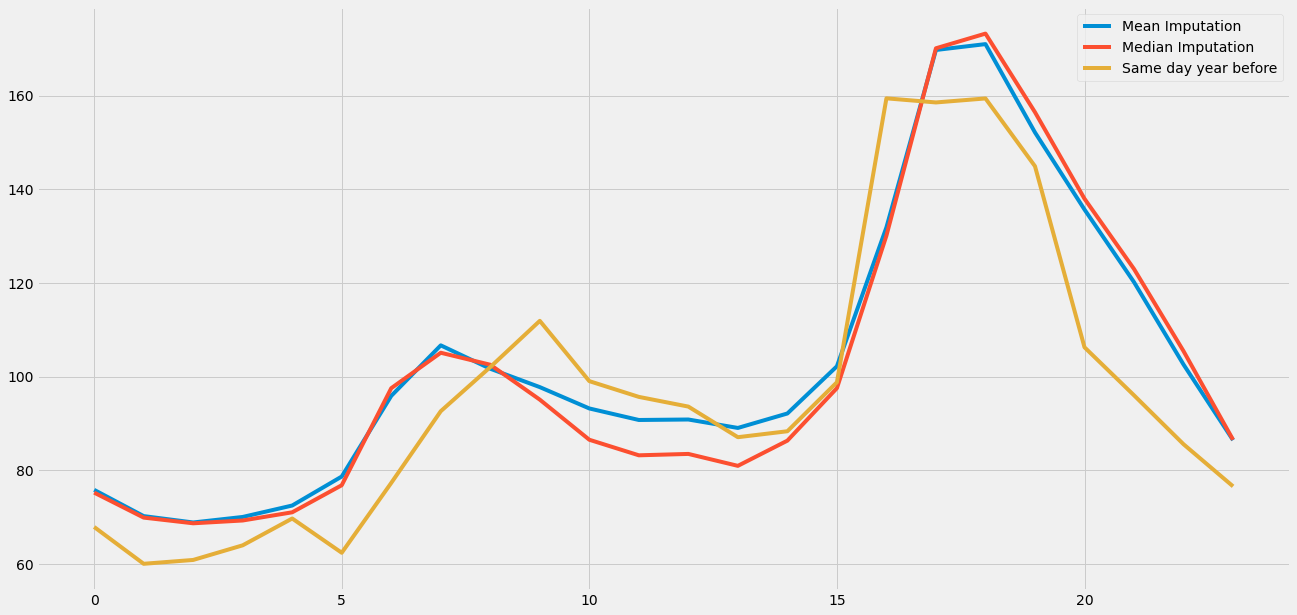

In [34]:
mn = []
md = []
sameday = kld[(kld.index >= dt.datetime(2019,10,19)) & (kld.index < dt.datetime(2019,10,20))].Value.tolist()
for t in range(24):
    mn.append(kld[(kld.index.hour == t) & (kld.index.quarter == 4)].mean()[0])
    md.append(kld[(kld.index.hour == t) & (kld.index.quarter == 4)].median()[0])
    

plt.plot(mn, label='Mean Imputation')
plt.plot(md, label='Median Imputation')
plt.plot(sameday, label='Same day year before')
plt.legend()
plt.show()

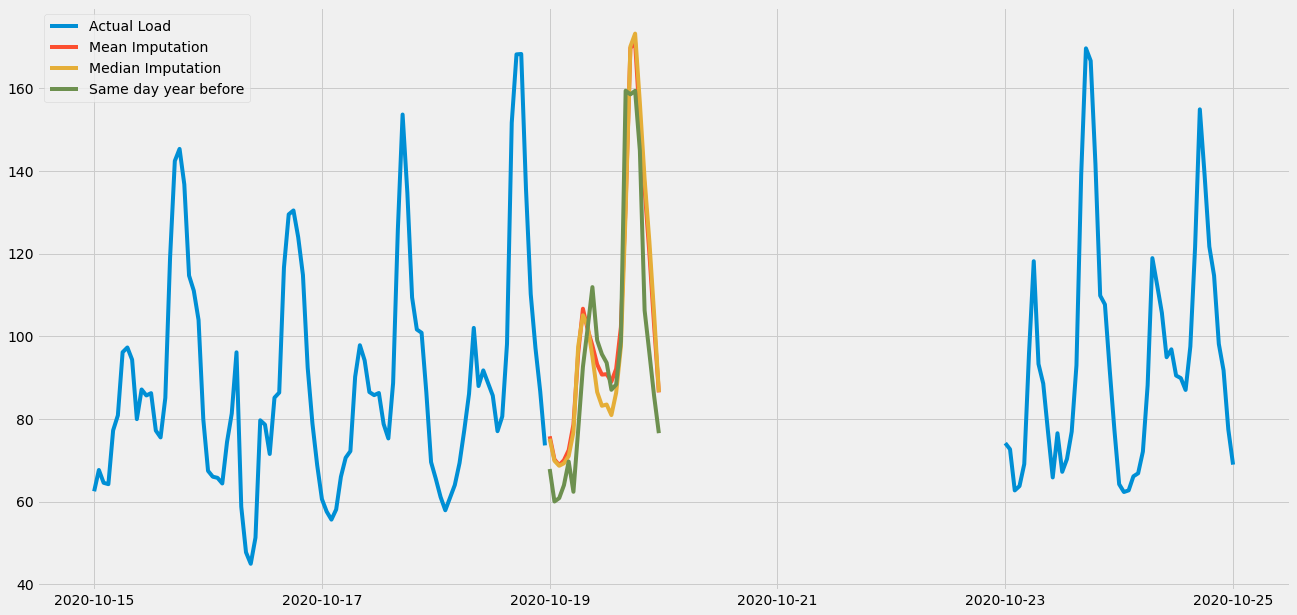

In [35]:
x = pd.date_range('2020-10-19', '2020-10-20', freq='H')
octkld = kld[(kld.index >= dt.datetime(2020,10,15)) & (kld.index <= dt.datetime(2020,10,25))]

plt.plot(octkld, label='Actual Load')
plt.plot(x[:-1], mn, label='Mean Imputation')
plt.plot(x[:-1], md, label='Median Imputation')
plt.plot(x[:-1], sameday, label='Same day year before')
plt.legend()
plt.show()

There are many ways to impute missing values for time series. The challenges for this dataset is the trend, seasonality and behavior of patterns in the data.  


In [29]:
def fillnans(df):
    for date in np.unique(df[df['Value'].isna() == True].index.date):
        df[df.index.date == date] = df[df.index.date == date - dt.timedelta(days=366)].values #leap year
    return df

In [30]:
kld = fillnans(kld)

# Preparing Strib Data

In [31]:
# Load Data
path = r'../data/strib/'
files = glob.glob(path + "/*.csv")

dfs = []

for file in files:
    df = pd.read_csv(file, index_col=None, header=0)
    dfs.append(df)

stb = pd.concat(dfs, axis=0, ignore_index=True)
stb.Datetime = pd.to_datetime(stb.Datetime)
stb = stb.groupby('Datetime').sum()

## Handling Missing Values

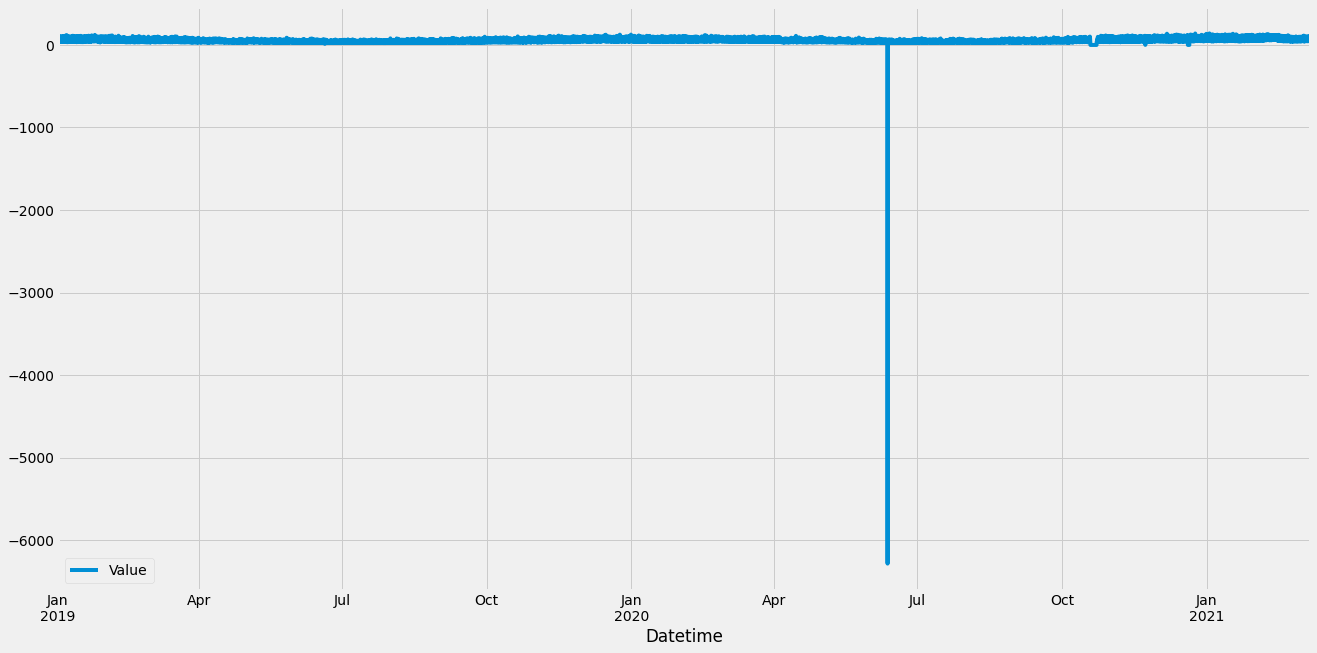

In [32]:
stb.plot()
plt.show()

Large negative values are a result of "sick" meters or meter resetting.

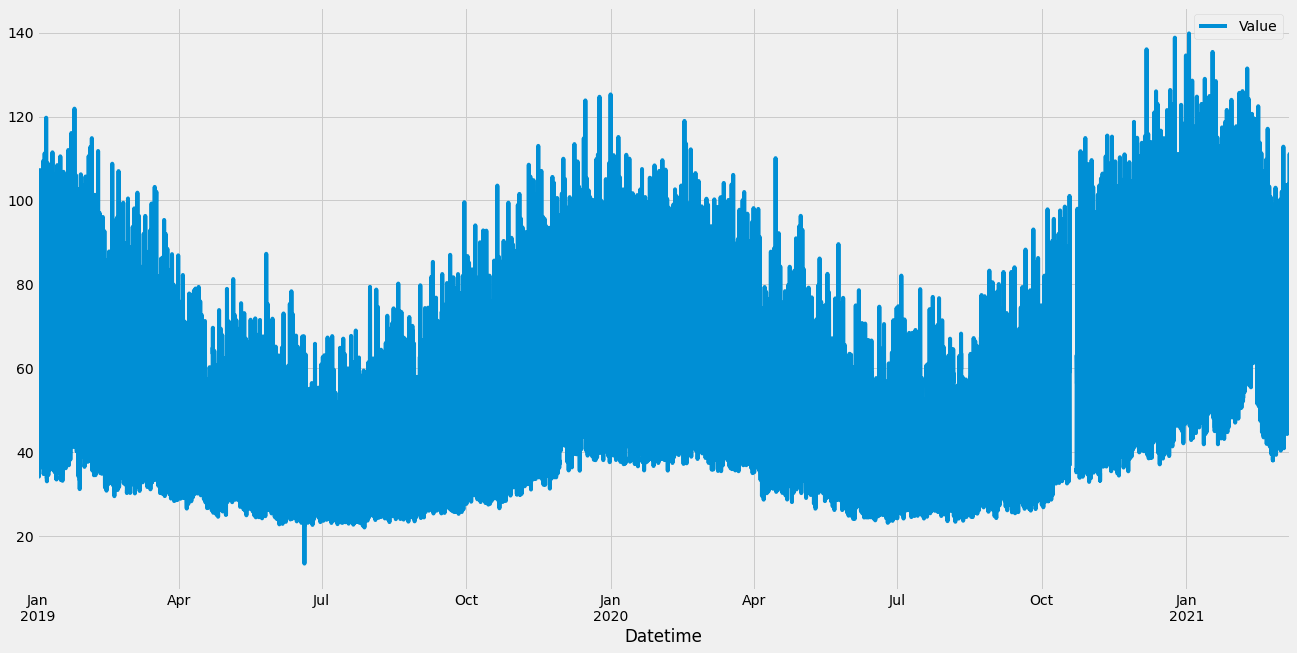

In [33]:
replacenan(stb)

stb.plot()
plt.show()

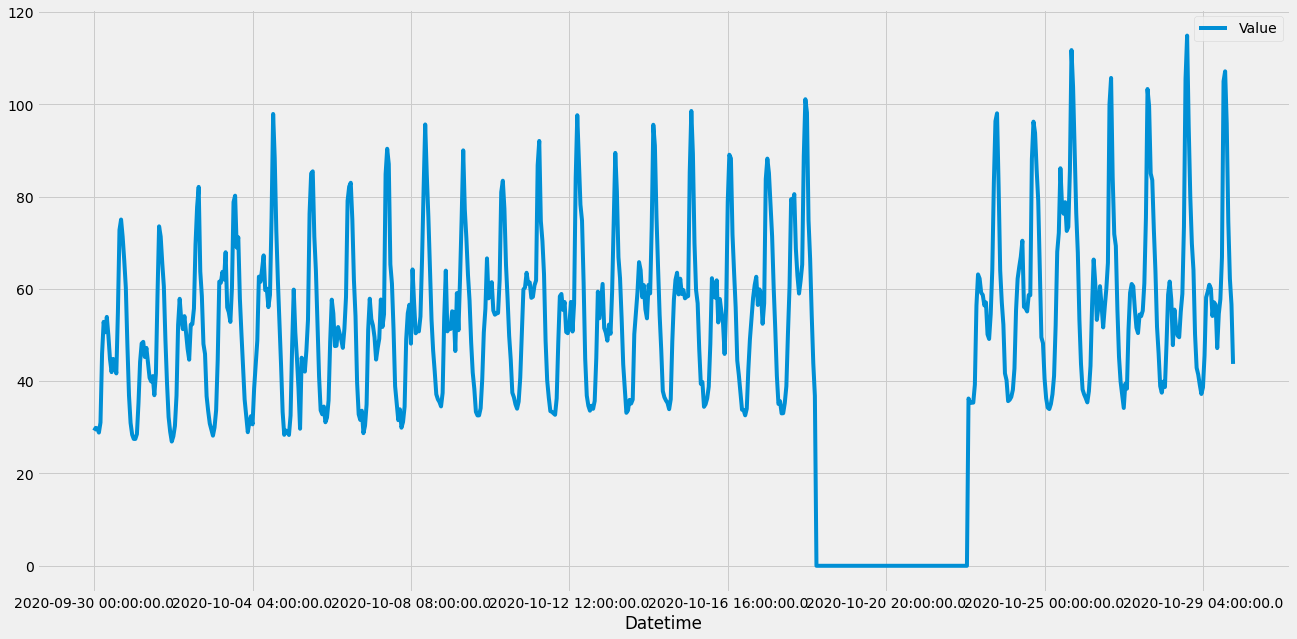

In [31]:
pd.read_csv('../data/strib/7_stb_202010.csv', index_col=None, header=0).groupby('Datetime').sum().plot()
plt.show()

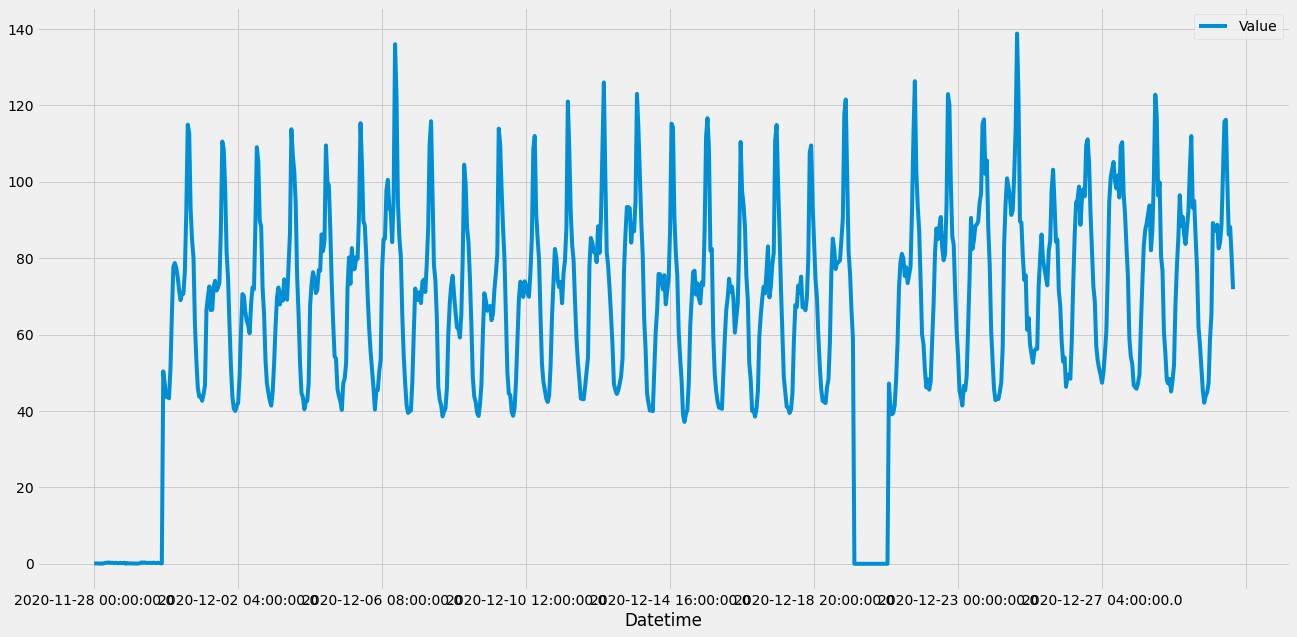

In [32]:
pd.read_csv('../data/strib/9_stb_202012.csv', index_col=None, header=0).groupby('Datetime').sum().plot()
plt.show()

In [34]:
stb = fillnans(stb)

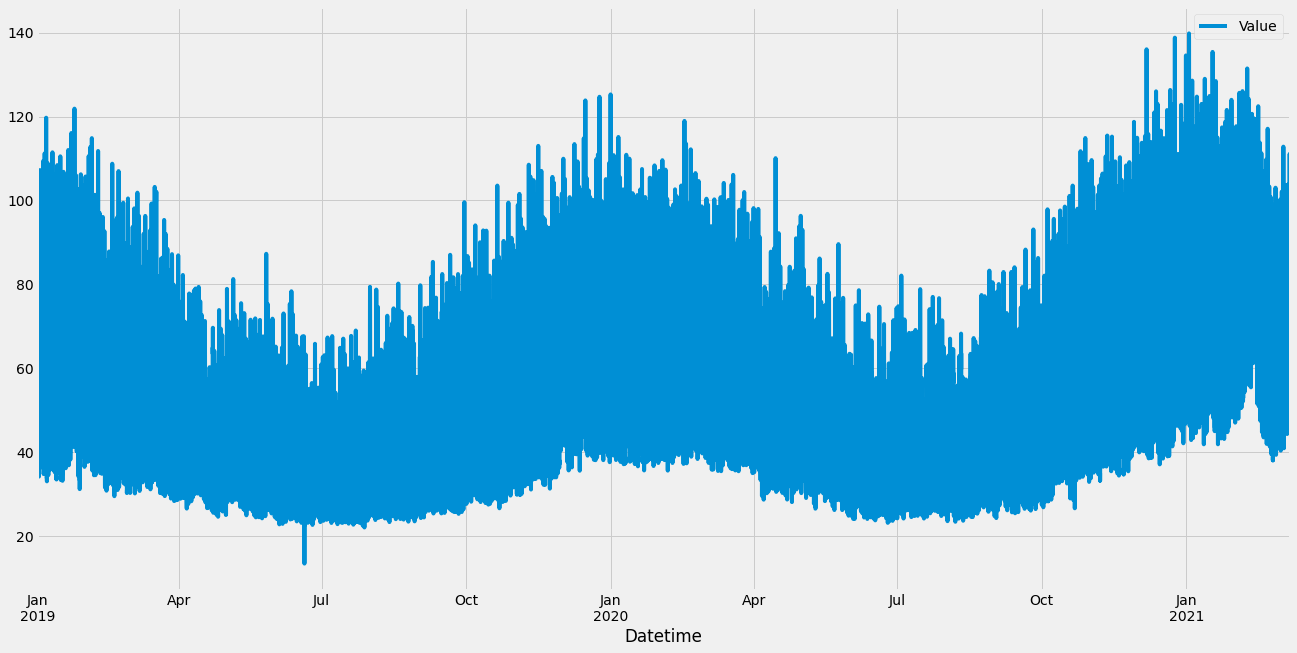

In [35]:
stb.plot()
plt.show()

### Introducing Weather Data

In [36]:
# Load Weather Data
weather = pd.read_csv('../data/weather_features.csv', header=0)
weather.Datetime = pd.to_datetime(weather.Datetime)
weather = weather.set_index('Datetime').sort_index()
#weather = weather[weather.index <= kld.index.max()]

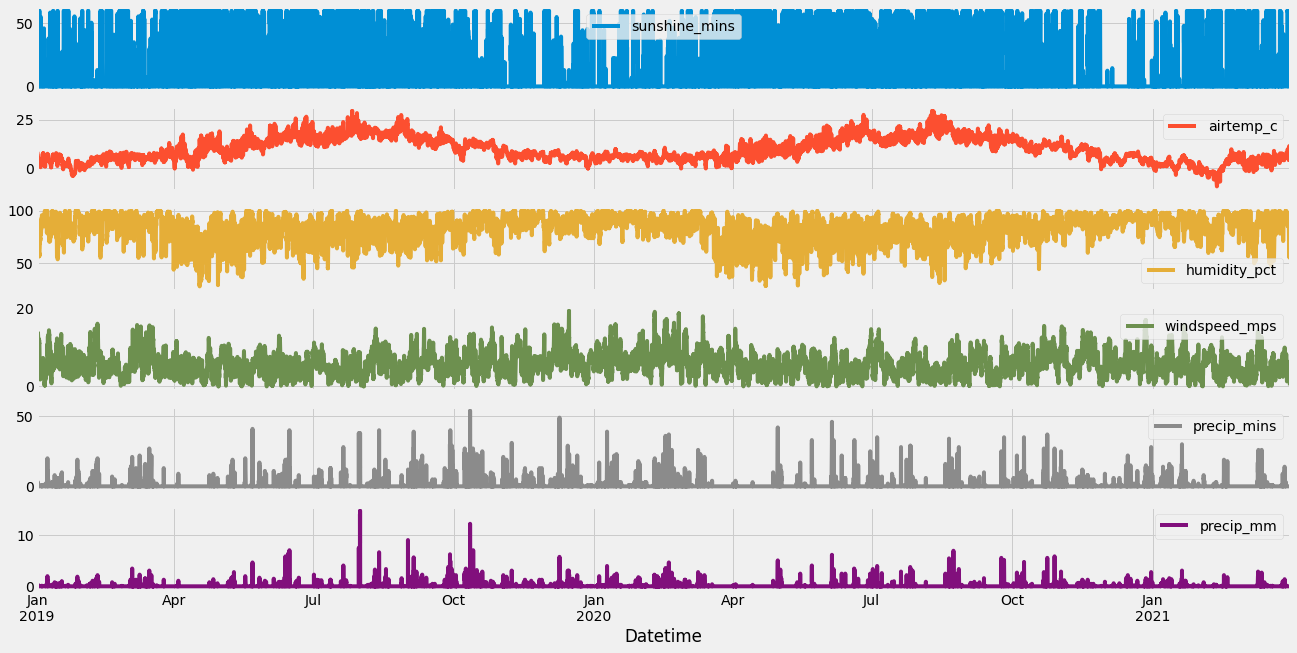

In [37]:
weather.plot(subplots=True)
plt.show()

In [55]:
kld_features = pd.merge(kld, weather, left_index=True, right_index=True)

In [56]:
stb_features = pd.merge(stb, weather, left_index=True, right_index=True)

### Daylength Data (Photoperiod)

In [57]:
daylengths = pd.read_csv('../data/daylengths.csv').transpose().iloc[1:]
daylengths.reset_index(inplace=True)
daylengths.columns = ['date', 'daylength_hrs']

daylengths['date'] = daylengths['date'].apply(lambda row: row[1:])
daylengths['date'] = pd.to_datetime(daylengths['date'], format='%Y.%m.%d')

daylengths.set_index('date', inplace=True)

daylengths.head()

,daylength_hrs
date,
2019-01-01,7.148307
2019-01-02,7.171043
2019-01-03,7.195853
2019-01-04,7.222702
2019-01-05,7.251554


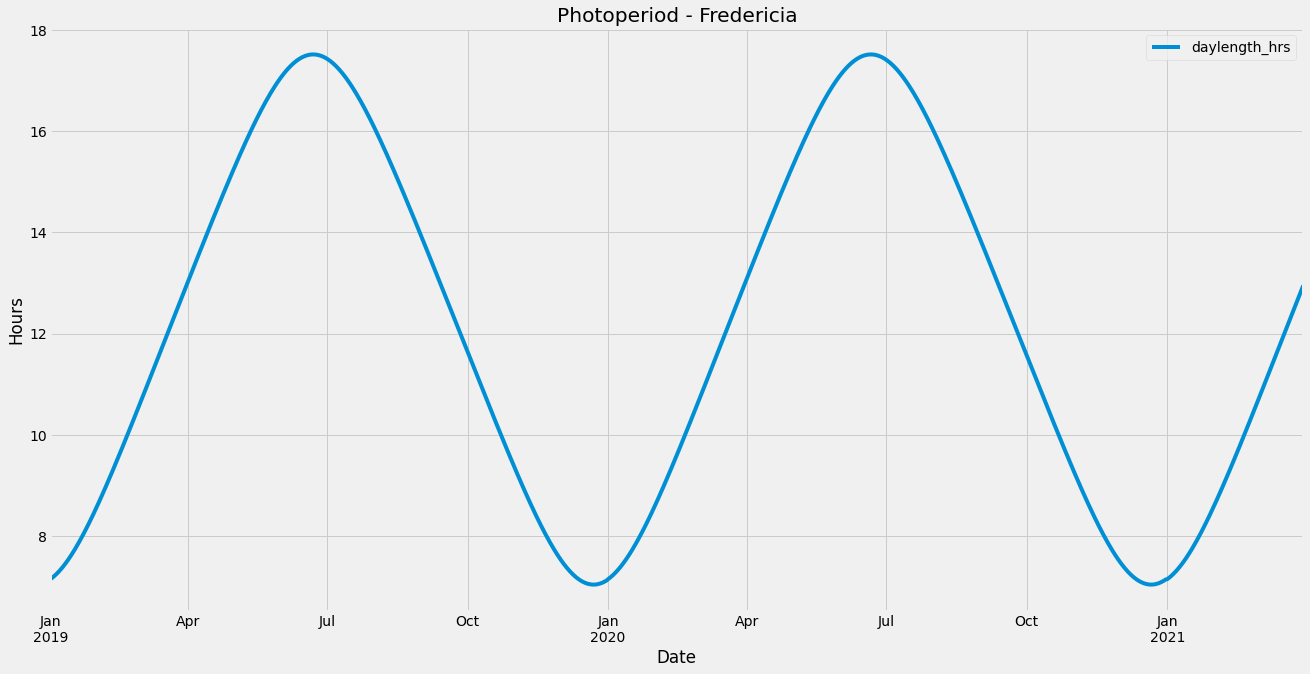

In [58]:
daylengths.plot()
plt.title('Photoperiod - Fredericia')
plt.xlabel('Date')
plt.ylabel('Hours')
plt.show()

In [59]:
kld_features = pd.merge(kld_features, daylengths, how='left', left_index=True, right_index=True)
kld_features['daylength_hrs'] = kld_features['daylength_hrs'].fillna(method='ffill')

In [60]:
stb_features = pd.merge(stb_features, daylengths, how='left', left_index=True, right_index=True)
stb_features['daylength_hrs'] = stb_features['daylength_hrs'].fillna(method='ffill')

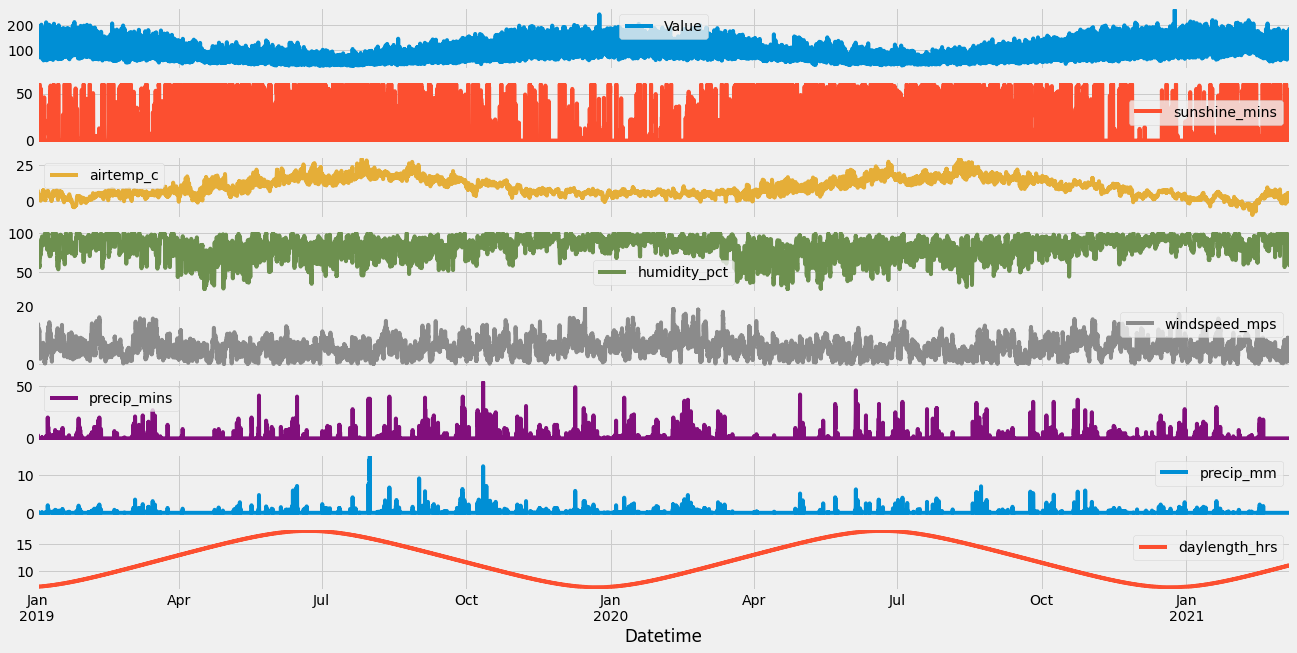

In [61]:
kld_features.plot(subplots=True)
plt.show()

In [62]:
kld_features.describe()

,Value,sunshine_mins,airtemp_c,humidity_pct,windspeed_mps,precip_mins,precip_mm,daylength_hrs
count,19128.000000,19128.000000,19128.000000,19128.000000,19128.000000,19128.000000,19128.000000,19128.000000
mean,89.699244,12.224723,9.736497,82.748325,5.807628,0.705249,0.083605,12.024117
std,32.450871,21.300142,6.111507,12.567877,2.954030,2.974317,0.421626,3.541560
min,35.904000,0.000000,-9.416667,28.166667,0.000000,0.000000,0.000000,7.040866
25%,65.604500,0.000000,5.183333,75.666667,3.683333,0.000000,0.000000,8.687297
50%,81.916000,0.000000,8.616667,85.333333,5.500000,0.000000,0.000000,11.715424
75%,106.816750,16.500000,14.550000,92.333333,7.583333,0.000000,0.000000,15.410708
max,263.164000,60.000000,29.566667,100.000000,19.400000,54.000000,14.900000,17.512735


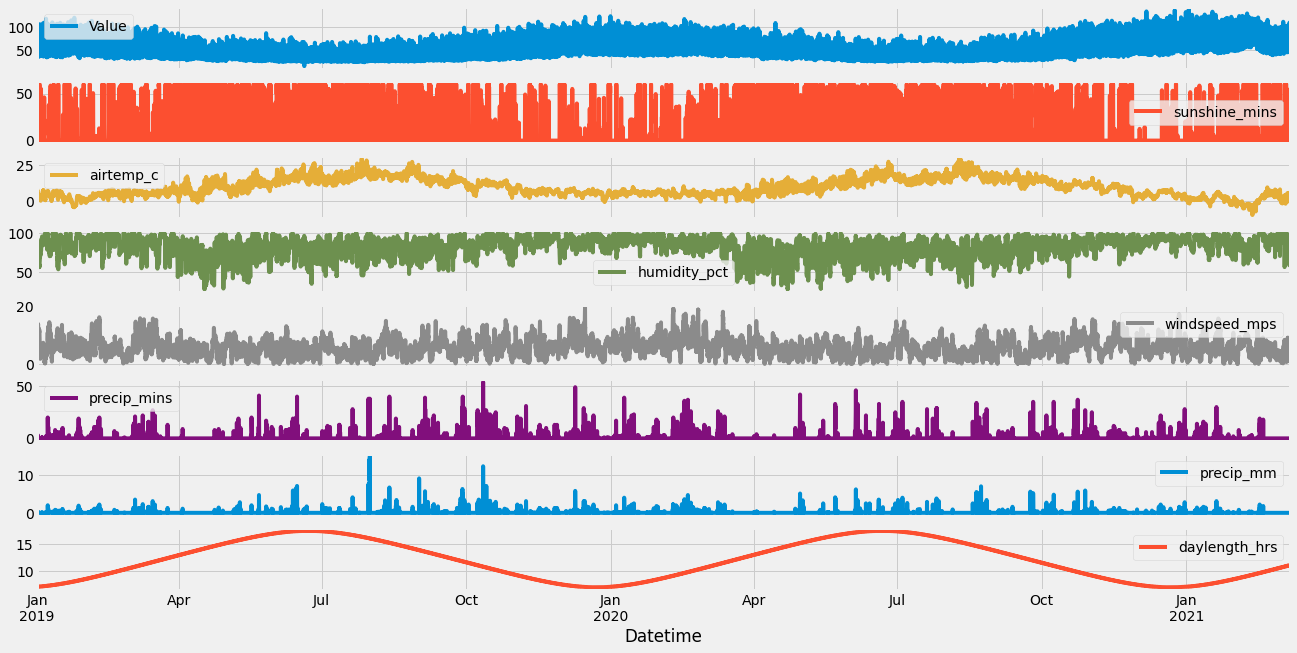

In [63]:
stb_features.plot(subplots=True)
plt.show()

In [64]:
stb_features.describe()

,Value,sunshine_mins,airtemp_c,humidity_pct,windspeed_mps,precip_mins,precip_mm,daylength_hrs
count,19128.000000,19128.000000,19128.000000,19128.000000,19128.000000,19128.000000,19128.000000,19128.000000
mean,53.935137,12.224723,9.736497,82.748325,5.807628,0.705249,0.083605,12.024117
std,19.381528,21.300142,6.111507,12.567877,2.954030,2.974317,0.421626,3.541560
min,13.515000,0.000000,-9.416667,28.166667,0.000000,0.000000,0.000000,7.040866
25%,39.616500,0.000000,5.183333,75.666667,3.683333,0.000000,0.000000,8.687297
50%,50.487000,0.000000,8.616667,85.333333,5.500000,0.000000,0.000000,11.715424
75%,64.883500,16.500000,14.550000,92.333333,7.583333,0.000000,0.000000,15.410708
max,139.792000,60.000000,29.566667,100.000000,19.400000,54.000000,14.900000,17.512735


In [66]:
kld_features.to_csv('../data/processed/kolding_features.csv', header=True)
stb_features.to_csv('../data/processed/strib_features.csv', header=True)

In [67]:
pd.read_csv('../data/processed/kolding_features.csv', index_col='Datetime', parse_dates=['Datetime'])

,Value,sunshine_mins,airtemp_c,humidity_pct,windspeed_mps,precip_mins,precip_mm,daylength_hrs
Datetime,,,,,,,,
2019-01-01 00:00:00,116.322,0.0,7.850000,87.833333,11.716667,0.0,0.0,7.148307
2019-01-01 01:00:00,102.681,0.0,7.883333,88.500000,11.983333,0.0,0.0,7.148307
2019-01-01 02:00:00,96.379,0.0,7.850000,91.500000,11.183333,0.0,0.0,7.148307
2019-01-01 03:00:00,85.352,0.0,7.983333,93.500000,10.516667,0.0,0.0,7.148307
2019-01-01 04:00:00,74.842,0.0,8.166667,83.333333,12.666667,1.0,0.1,7.148307
...,...,...,...,...,...,...,...,...
2021-03-07 19:00:00,177.618,0.0,1.283333,73.833333,2.283333,0.0,0.0,11.105232
2021-03-07 20:00:00,144.463,0.0,1.050000,70.833333,2.350000,0.0,0.0,11.105232
2021-03-07 21:00:00,133.288,0.0,-0.033333,79.333333,1.450000,0.0,0.0,11.105232
